                                                       ИМПОРТИРОВАНИЕ МОДУЛЕЙ

In [1]:
import scipy.stats as sps
import scipy.optimize as spo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import pyreadr

                                              П Р И К Л А Д Н Ы Е      Ф У Н К Ц И И

In [2]:
def normal_array(N,T,mu,sigma):
    A=np.zeros([N,T])
    for i in range(N):
        A[i,:]=sps.norm.rvs(loc=mu,scale=sigma,size=T)
    return A

##############################################################################################################################

# ЗНАЧЕНИЯ ОБРАТНОЙ ФУНКЦИИ

def solve_eq(f,a,b,thres):  # решение уравнения f(x)=0 на отрезке [a,b] с точностью thres методом деления отрезка пополам
    y_a=f(a)
    y_b=f(b)
    direction=f(b)-f(a)
    if not y_a*y_b<0:
        print("ЗНАКИ ФУНКЦИИ НА КОНЦАХ ОТРЕЗКА СОВПАДАЮТ")
        return None
    dif=b-a
    while dif>thres:
        c=a+(b-a)/2
        y=f(c)
        if y==0:
            return c
        if y*direction>0:
            b=c
        else:
            a=c
        dif=b-a
    return b

################################################################################################################################

# ПРЕОБРАЗОВАНИЕ ФИШЕРА
def Z_Fisher(x):
    return 0.5*np.log((1+x)/(1-x))

#################################################################################################################################

# ЭМПИРИЧЕСКАЯ ПЛОТНОСТЬ
def empiric_density(data, number_breaks, mindata, maxdata):                      # data - np.array(N,);   N=data.shape[0]
    data=np.array(data)
    step=(maxdata-mindata)/number_breaks
    breaks=mindata+step*range(0,number_breaks+1)
    mids=mindata+step/2+step*range(0,number_breaks)
    density=(maxdata-mindata)/(max(data)-min(data))*np.histogram(data,bins=number_breaks,range=(mindata, maxdata),density=True)[0]
    # эмпирическая плотность отнормирована на диапазон - интеграл от плотности на диапазоне равен единице
    return([mids],[density])
##################################################################################################################################

# ИЗВЛЕКАЕТ ИЗ ФУНКЦИИ empiric_density ЧАСТОСТИ КАК np.array (n,)

def Y_density(data):
    return np.array(empiric_density(data, number_breaks=round(data.shape[0]/10),mindata=min(data), maxdata=max(data)))[1,0,:]
                                                 


##################################################################################################################################

# ЭМПИРИЧЕСКАЯ ПЛОТНОСТЬ И ЕЕ ГРАФИК
    # На график эмпирической плотности можно накладывать различные кривые

def Empiric_density(data, number_breaks, F,colors,mindata, maxdata,MEAN):
    # data - np.array (одномерный)
    # F - список функций
    # colors - список цветов
    # mindata,maxdata - границы графика
    # MEAN - если MEAN=True, наносится вертикальная линия - среднее значение data
    Dens=empiric_density(data, number_breaks, mindata, maxdata)
    plt.figure()
    X1=list()
    Y1=list()
    
    for i in range(Dens[0][0].shape[0]):
        X1.append(np.array(Dens[0])[0,i])
        Y1.append(np.array(Dens[1])[0,i])
    Z=np.zeros([len(F),Dens[0][0].shape[0]])
    plt.plot(X1,Y1,'b')
    for i in range(len(F)):
        Z[i,:]=np.vectorize(F[i])(X1)
        plt.plot(X1,Z[i],color=colors[i])
    plt.title('EMPIRIC DENSITY')
    plt.xlabel('breaks')
    plt.ylabel('probabilities')
    plt.grid()
    plt.axvline(lw=3,color='k',x=0)
    plt.axhline(lw=3,color='k',y=0)
    if MEAN==True:
        plt.axvline(lw=3,color='g',x=np.mean(data))
    return plt.show
#########################################################################################################################################

# КВАНТИЛЬ ЭМПИРИЧЕСКОГО РАСПРЕДЕЛЕНИЯ

def empiric_ppf(data,alpha):
    data=list(data)
    sorted_data=sorted(data)
    return sorted_data[round(alpha*len(data))]

In [3]:
                                                                    Д И С П Е Р С И Я

SyntaxError: invalid syntax (221314778.py, line 1)

In [ ]:
                                                                Нормальное распределение

In [4]:
def var_norm_boards(n,disp,alpha):  # n - объем выборки, disp - несмещенная оценка дисперсии, alpha - уровень значимости
    left=(n-1)*disp/sps.chi2.ppf(q=1-alpha/2,df=n-1)
    right=(n-1)*disp/sps.chi2.ppf(q=alpha/2,df=n-1)
    return [left,right]


In [ ]:
                                                                   Гамма-распределение

<function matplotlib.pyplot.show(close=None, block=None)>

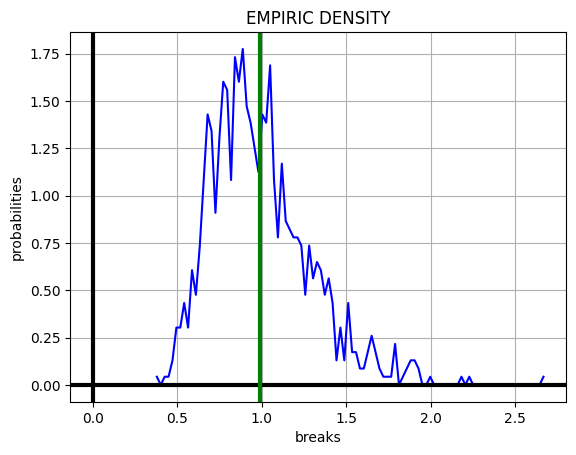

In [5]:
N_gamma=1000
T_gamma=100
X_gamma=np.zeros([N_gamma,T_gamma])
for i in range(N_gamma):
    X_gamma[i,:]=sps.gamma.rvs(a=1,size=T_gamma)
Gamma_vars=np.var(X_gamma,ddof=1,axis=1)
Empiric_density(Gamma_vars, number_breaks=round(Gamma_vars.shape[0]/10), F=[],colors=[],
                mindata=min(Gamma_vars), maxdata=max(Gamma_vars),MEAN=True)

In [6]:
sps.fit(sps.chi2,Y_density(Gamma_vars),bounds=((0,1000),(-100,100),(0,100)))

  params: FitParams(df=0.16301057325426882, loc=-1.1102230246251565e-14, scale=3.0842116340966257)
 success: True
 message: 'Optimization terminated successfully.'

<function matplotlib.pyplot.show(close=None, block=None)>

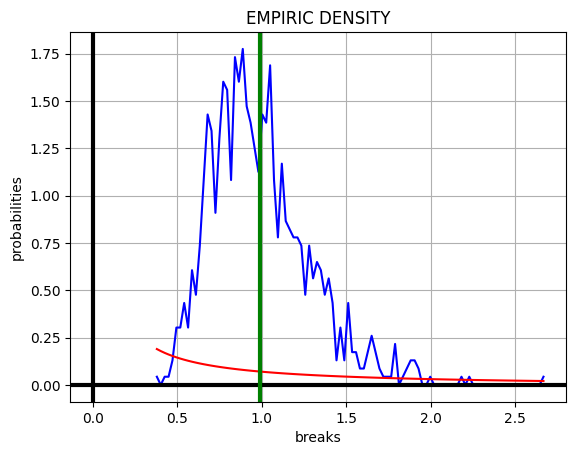

In [7]:
def fit_gamma_vars(x):
    return sps.chi2.pdf(x,df=0.1892851530062103, loc=-1.1102230246251565e-14, scale=2.52641116772957)
Empiric_density(Gamma_vars, number_breaks=round(Gamma_vars.shape[0]/10), F=[fit_gamma_vars],colors=['r'],
                mindata=min(Gamma_vars), maxdata=max(Gamma_vars),MEAN=True)

                                                             Метод Монте-Карло

In [15]:
alpha = 1

[0.9606952816915546, 0.9606952816915546]

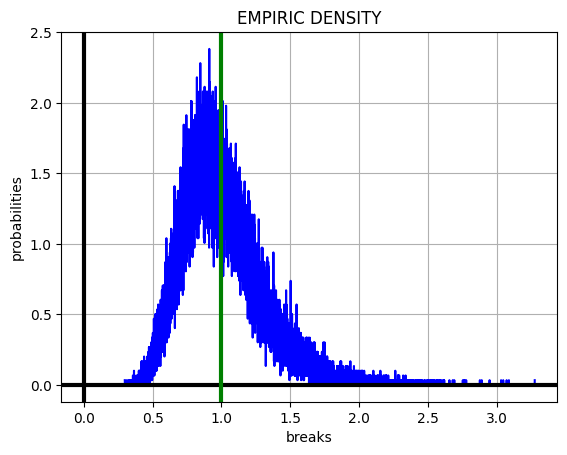

In [16]:
N_gamma=100000
T_gamma=100
X_gamma=np.zeros([N_gamma,T_gamma])
for i in range(N_gamma):
    X_gamma[i,:]=sps.gamma.rvs(a=1,size=T_gamma)
Gamma_vars=np.var(X_gamma,ddof=1,axis=1)
Empiric_density(Gamma_vars, number_breaks=round(Gamma_vars.shape[0]/10), F=[],colors=[],
                mindata=min(Gamma_vars), maxdata=max(Gamma_vars),MEAN=True)
Gamma_var_statistic=[np.mean(Gamma_vars),np.var(Gamma_vars,ddof=1)]
Gamma_var_statistic
left=empiric_ppf(Gamma_vars,alpha/2)
right=empiric_ppf(Gamma_vars,1-alpha/2)
[left,right]

In [ ]:
                                                                    М Е Д И А Н А

In [18]:
N_median=1000
T_median=100
alpha = 1
Gamma_Array=gamma_array(N_median,T_median, alpha)
gamma_median=np.zeros(N_median)
for i in range(N_median):
    gamma_median[i]=empiric_ppf(Gamma_Array[i],0.5)
[np.mean(gamma_median),np.std(gamma_median)]

NameError: name 'Gamma_array' is not defined

In [13]:
N_median=1000
T_median=100
mu=0
sigma=1
Normal_Array=normal_array(N_median,T_median,mu,sigma)
normal_median=np.zeros(N_median)
for i in range(N_median):
    normal_median[i]=empiric_ppf(Normal_Array[i],0.5)
[np.mean(normal_median),np.std(normal_median)]

[0.01041709725105115, 0.12611598058008322]

In [ ]:
def gamma_median_pdf(x):
    return sps.norm.pdf(x,loc=np.mean(normal_median),scale=np.std(normal_median))

Empiric_density(normal_median, number_breaks=round(normal_median.shape[0]/10), F=[normal_median_pdf],colors=['r'],
                mindata=min(normal_median), maxdata=max(normal_median),MEAN=True)      

<function matplotlib.pyplot.show(close=None, block=None)>

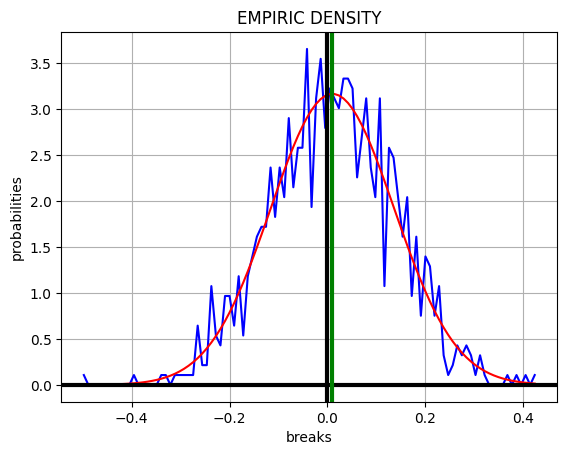

In [14]:
# def normal_median_pdf(x):
    # return sps.norm.pdf(x,loc=np.mean(normal_median),scale=np.std(normal_median))

Empiric_density(normal_median, number_breaks=round(gamma_median.shape[0]/10), F=[normal_median_pdf],colors=['r'],
                mindata=min(gamma_median), maxdata=max(gamma_median),MEAN=True)                          

In [ ]:
                                                       К О Э Ф Ф И Ц И Е Н Т      К О Р Р Е Л Я Ц И И

                                                      Н о р м а л ь н о е     р а с п р е д е л е н и е

In [ ]:
                      # ФОРМИРОВАНИЕ ВЫБОРОК

N_norm=1000               # Генерируется N_norm двумерных нормальных выборок длины T_norm
T_norm=20

# Выбор параметров
mu=[0,0]                  # Математическое ожидание
r=0.5                     # Корреляция между компонентами
cov=np.zeros([2,2])       # Матрица ковариации
cov[0,:]=[1,r]
cov[1,:]=[r,1]

# Генерация
X_norm=np.zeros([N_norm,T_norm,2])
for i in range(N_norm):
    X_norm[i,:,:]=sps.multivariate_normal.rvs(mean=mu,cov=cov,size=T_norm)

# Выборочные корреляции
cor_norm=[]
for i in range(N_norm):
    cor_norm.append(np.corrcoef(X_norm[i,:,:],rowvar=False)[0,1])
cor_norm=np.array(cor_norm)

                                              Нормальная аппроксимация (справедлива для больших выборок)

In [ ]:
def mu_approx(r):
    return r
def std_approx(n,r):
    return (1-r**2)/(n-1)**0.5
def Cor_norm(x):
    return sps.norm.pdf(x,loc=r,scale=std_approx(T_norm,r))
Empiric_density(data=cor_norm,number_breaks=round(cor_norm.shape[0]/10),
                                F=[Cor_norm],colors=['r'],
                                mindata=min(cor_norm),maxdata=max(cor_norm),MEAN=True)

                                                           Преобразование Фишера

In [ ]:
# Преобразование Фишера - стандартный инструмент исследования распределения выборочной корреляции

cor_Z_norm=Z_Fisher(cor_norm)                                # Преобразование Фишера выборочного коэффициента корреляции
def EZ(n,r):
    return Z_Fisher(r)+r/(2*(n-1))                                  # Математическое ожидание Z_Fisher(r)
def DZ(n,r):
    return 1/(n-3)                                                  # Дисперсия Z_Fisher(r)

In [ ]:
# Распределение преобразования Фишера выборочного коээффициента корреляции

def Z_cor(x):
    return sps.norm.pdf(x,loc=Z_Fisher(r)+r/(2*(T_norm-1)),scale=(1/(T_norm-3)**0.5))
    
Empiric_density(data=cor_Z_norm,number_breaks=round(cor_Z_norm.shape[0]/10),
                                F=[Z_cor],colors=['r'],
                                mindata=min(cor_Z_norm),maxdata=max(cor_Z_norm),MEAN=True)

                                                 ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ КОЭФФИЦИЕНТА КОРРЕЛЯЦИИ

                                         Доверительный интервал на основе использования преобразования Фишера

In [ ]:
def F_left(n,rho,r,alpha):
    return EZ(n,rho)-(Z_Fisher(r)-sps.norm.ppf(q=1-alpha/2)*DZ(n,r)**0.5)
def F_right(n,rho,r,alpha):
    return EZ(n,rho)-(Z_Fisher(r)+sps.norm.ppf(q=1-alpha/2)*DZ(n,r)**0.5)
    
n_sample=100
r_sample=0.5
alpha=0.05


def Right_rho(rho):
    return F_right(n_sample,rho,r_sample,alpha)
def Left_rho(rho):
    return F_left(n_sample,rho,r_sample,alpha)

rho_right=solve_eq(Right_rho,0.0001,0.9999,0.001)
rho_left=solve_eq(Left_rho,0.0001,0.9999,0.001)
[rho_left,rho_right]  

                                    Приближенный доверительный интервал в случае сравнительно больших выборок

In [ ]:
def cor_boards_large_samples(n,r,alpha):
    Z=0.5*np.log((1+r)/(1-r))         # Преобразование Фишера выборочного коэффициента корреляции
    t=sps.norm.ppf(1-alpha/2)         # Квантиль нормального распределения
    g_left=np.exp(2*Z-2*t/(n-3)**0.5)-1
    h_left=np.exp(2*Z-2*t/(n-3)**0.5)+1
    g_right=np.exp(2*Z+2*t/(n-3)**0.5)-1
    h_right=np.exp(2*Z+2*t/(n-3)**0.5)+1
    return [g_left/h_left, g_right/h_right]
cor_boards_large_samples(n_sample,r_sample,alpha)    

                   Приближенный доверительный интервал на основе допущения нормального распределения выборочной корреляции

In [ ]:
def cor_approx_boards(n,r,alpha):
    left=r-sps.norm.ppf(1-alpha/2)*std_approx(n,r)
    right=r+sps.norm.ppf(1-alpha/2)*std_approx(n,r)
    return [left,right]
cor_approx_boards(n_sample,r_sample,alpha)

                                          Распределение статистики Стьюдента для коэффициента корреляции

In [ ]:
cor_t_norm=(cor_norm)*(T_norm-2)**0.5/(1-(cor_norm)**2)**0.5
def t(x):
    return sps.t.pdf(x,df=T_norm)
Empiric_density(data=cor_t_norm,number_breaks=round(cor_t_norm.shape[0]/10),
                                F=[t],colors=['r'],
                                mindata=min(cor_t_norm),maxdata=max(cor_t_norm),MEAN=True)

In [ ]:
                               А л ь т е р н а т и в н о е     р а с п р е д е л е н и е     (Д и р и х л е)

In [ ]:
N_t=1000
T_t=100
X_t=np.zeros([N_t,T_t,2])
for i in range(N_t):
    X_t[i,:,:]=sps.t.rvs(,size=T_dir)
X_dir[0,:,:]
YYY=X_dir[0,:,0]
ZZZ=X_dir[0,:,1]
np.corrcoef(YYY,ZZZ)[0,1]
plt.plot(YYY,ZZZ)

In [ ]:
    
# Выборочные корреляции
cor_dir=[]
for i in range(N_dir):
    cor_dir.append(np.corrcoef(X_dir[i,:,:],rowvar=False)[0,1])
cor_dir=np.array(cor_dir)
cor_dir

In [ ]:
DJ=pyreadr.read_r("C:\\РАБОТА\\R\\R-DATA\\US_EQUITIES.RData")   # словарь, полученный из данных R
CLOSE_DAILY=DJ['CLOSE_DAILY']                                     #  DataFrame цен, полученная по выбору ключа словаря
PRICES=CLOSE_DAILY.to_numpy()                                     #  Массив цен
RET=np.diff(np.log(PRICES),axis=0)                                #  Доходности
